# (some) Related Work

# Abstract

# Intro to Numba
In the next section we will be needing some speed to run some tests. Python isn't known for speed. We will for now use numba to speed up Python because it requires basically the no amount of effort (for simple code) if you already know Python just some details you have to know. 

## What is Numba
Go see https://numba.pydata.org/. <br>
Numba translates Python functions to optimized machine code at runtime using the industry-standard LLVM compiler library. Numba-compiled numerical algorithms in Python can approach the speeds of C or FORTRAN.

You don't need to replace the Python interpreter, run a separate compilation step, or even have a C/C++ compiler installed. Just apply one of the Numba decorators to your Python function, and Numba does the rest. <br>

## Installation
We installed numba via anaconda (conda install numba). We think you can also install it with pip if you have the correct version of Python.

## Example
Here is a quick example to get your feet wet:

In [45]:
from random import random
from numba import njit, prange

# normal way:
def Y(t): return 1 + (Y(random()*t) if random()<t else 0)
def y(t,nsim): return sum(Y(t) for _ in range(nsim))/nsim

# numba way:
@njit(fastmath=True)
def Yn(t): return 1.0 + (Yn(random()*t) if random()<t else 0.0)

@njit(fastmath=True, parallel=True)
def yn(t, nsim):
    total = 0.0 # <- typing becomes important 0 vs 0.0
    for _ in prange(nsim):
        total += Yn(t)
    return total/nsim

In [49]:
t,nsim = 1,10**5
%timeit y(t,nsim)
%timeit yn(t,nsim)

215 ms ± 89.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.77 ms ± 295 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In this example numba speeded up the running time 40 times (on our laptop) with minor changes (typing, decorators, parallel). 

## Disadvantages
Here are some of the main drawbacks of using Numba:

-   Limited support for Python features: Numba supports a limited subset of Python features, which means that not all Python code can be accelerated with Numba.

-   Compilation time: Numba needs to compile the code before it can execute it, which can take some time. This overhead can be significant for small computations, making it less efficient than native Python.

-   Memory usage: Numba can increase the memory usage of Python programs, which can be a problem for large-scale computations.

-   Debugging: Numba can make debugging more difficult, as the compiled code is not as easy to read and understand as native Python code.



# Half Variance Phenomenon
Ok we need a better name for this. The half variance phenomenon is the order improvement of turning classic deterministic integrators into Monte Carlo ones. The order improvement happens because of instead summing errors you sum variances which after taking the $\sqrt{ }$ end up reducing the order less. <br>

To demonstrate the half variance phenomenon we compare the classic trapezium rule vs the MC trapezium rule. In $1$ dimensional integration we get a free half order of convergence, in $d$ dimensional this becomes $\frac{d}{2}$.
## 1D MC Trapezium Rule

In [44]:
from random import random
from math import exp
from numba import njit, prange
from functools import lru_cache
import numpy as np
import matplotlib.pyplot as plt

#@lru_cache(maxsize=4)
@njit
def f(x): return exp(x) 
    
@njit(fastmath=True)
def trapezium(n,a,b):
    dx = (b-a)/n
    x,sol = 0,0
    for _ in range(n):
        xx = x + dx
        sol += (f(x)+f(xx))/2 # inefficient
        x = xx
    return sol*dx

@njit(fastmath=True)
def MCtrapezium(n,a,b):
    dx = (b-a)/n
    x,sol = 0,0
    for _ in range(n):
        xx = x + dx
        sol += (f(x)+f(xx))/2 # inefficient
        l = 20 # russian roulette rate l**2 influence on variance
        if random()*l<1:
            U = x + random()*(xx-x) # \sim Uniform(x,xx)
            sol += l*(f(U)-f(x)-(U-x)*(f(xx)-f(x))/dx)
        x = xx
    return sol*dx

def exactX(a,b): return exp(b)-exp(a) 

def MCtrap_llplot():
    n,a,b = 100,0,1
    DTS = np.power(2,np.array(range(24)))
    errors = np.array([(abs(trapezium(n,a,b)-exactX(a,b)))/(exactX(a,b)) for n in DTS])
    MCerrors = np.array([(abs(MCtrapezium(n,a,b)-exactX(a,b)))/(exactX(a,b)) for n in DTS])
    plt.plot(np.log(DTS),np.log(errors*5), label = "OG trap")
    plt.plot(np.log(DTS),np.log(MCerrors*5), label = "MC trap")
    dgs = [1,2,2.5]
    for l in dgs:
        ref = np.array([pow(1/d,l) for d in DTS])
        plt.plot(np.log(DTS),np.log(ref),label =f"d**-{l}")
    plt.legend()
    plt.title("log log plot")
    plt.show()

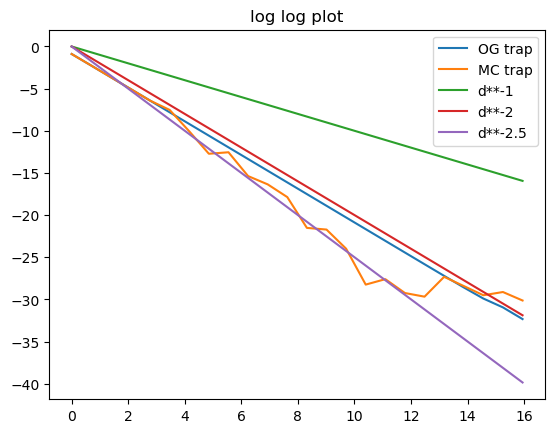

In [45]:
MCtrap_llplot()

we don't know what goes wrong in the convergence probably numerical precision stuff ... 

## 2D MC Trapezium Rule 

In [20]:
from random import random
from math import exp
from numba import njit, prange
from functools import lru_cache
import numpy as np
import matplotlib.pyplot as plt

#@lru_cache(maxsize=4)
@njit
def f2(x,y): return exp(x)*exp(y)

@njit(fastmath=True)
def trapezium2(n):
    d = 1/n
    x,sol = 0,0
    for _ in range(n):
        y = 0
        for _ in range(n):
            sol += ((f2(x+d,y)+f2(x,y+d))/2 )*d**2 # inefficient
            y +=d
        x+=d
    return sol

@njit(fastmath=True)
def MCtrapezium2(n):
    d = 1/n
    x,sol = 0,0
    for _ in range(n):
        y = 0
        for _ in range(n):
            sol += ((f2(x+d,y)+f2(x,y+d))/2 )*d**2 # inefficient
            l = 5 # russian roulette rate l>1
            if random()*l<1:
                X,Y = x + d*random(), y + d*random()
                sol += l*(f2(X,Y)-(f2(x,y)+(f2(x+d,y)-f2(x,y))*(X-x)/d+(f2(x,y+d)-f2(x,y))*(Y-y)/d))*d**2 
            y +=d
        x+=d
    return sol

def exact2(): return (exp(1)-1)**2

def MCtrap2_llplot():
    DTS = np.power(2,np.array(range(13)))
    errors = np.array([(abs(trapezium2(n)-exact2()))/(exact2()) for n in DTS])
    MCerrors = np.array([(abs(MCtrapezium2(n)-exact2()))/(exact2()) for n in DTS])
    plt.plot(np.log(DTS),np.log(errors*5), label = "OG trap2")
    plt.plot(np.log(DTS),np.log(MCerrors*5), label = "MC trap2")
    dgs = [1,2,2.5,3]
    for l in dgs:
        ref = np.array([pow(1/d,l) for d in DTS])
        plt.plot(np.log(DTS),np.log(ref),label =f"d**-{l}")
    plt.legend()
    plt.title("log log plot")
    plt.show()

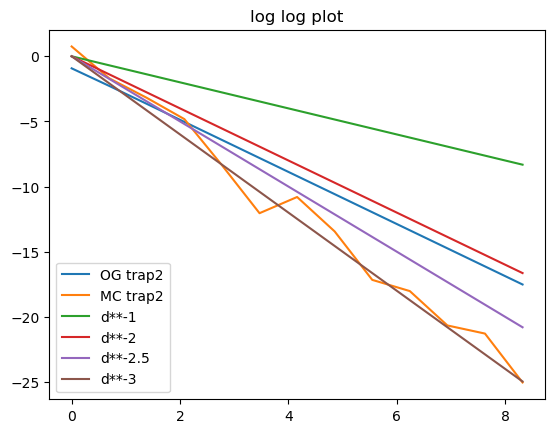

In [42]:
MCtrap2_llplot()

# Sensitivity of Random Variables

We don't know if this has solid footing but we find it intrestring. Say we have a RV that depends on a parameter and we want to know how small variations of that parameter influence that RV (like a derivative). We "define" the sensitivity of a RV with respect to a parameter by rewriting that RV such that the parameter doesn't appear in the random part and then taking the regular derivative of that expression. We haven't proofed that this definition is water tight but think it is a lead to something useful.  

## Examples

Let $U \sim \text{Uniform}(0,1)$. In what follows $U$ will be the same random variable when it pops up in the same expression. 
### Example 1
$$
\partial_{t}(U^{t}) = \ln{(U)} U^{t}.
$$ 
### Example 2
Lets do a RMC example (product rule + chain rule):
$$
\begin{align*}
Y(t)&= 1 + t Y(Ut) \\
\partial_{t}Y(t)&= t U \partial_{t}Y(Ut) + Y(Ut)
\end{align*}
$$ 
we are actually only interested if the expectation of the sensitivity are right. We test this in a implementation:

In [52]:
from random import random
from numba import njit, prange
import numpy as np

@njit(fastmath=True)
def X(t):
    if random()>t: return np.array((1.0,0.0))
    U = random()
    ys,dys = X(U*t)
    yt = 1.0 + ys
    dyt = ys/t + U*dys
    return np.array((yt,dyt))

@njit(fastmath=True, parallel=True)
def x(t, nsim):
    total = np.zeros(2) 
    for _ in prange(nsim):
        total += X(t)
    return total/nsim

In [63]:
print(x(1,10**6))

[2.717896 2.718215]


### Example 3
Another RMC example:
$$
\begin{align*}
Y(t,a)&= 1 + ta Y(Ut,a) \\
\partial_{a}Y(t,a)&= t (Y(Ut,a) + a \partial_{a}Y(Ut,a) )
\end{align*}
$$ 
Remember that $E(t,a) = e^{ta}$. Lets implement this:

In [65]:
from random import random
from math import exp
import numpy as np

def X2(t,a):
    if random()>t: return np.array((1,0)) 
    U = random()
    ys,days = X2(U*t,a) 
    yt = 1 + a*ys*(1 if t<1 else t)
    dayt = (ys + a*days)*(1 if t<1 else t)
    return np.array((yt,dayt))

def test_dRV3():
    t, a, nsim = 1.2, 2, 10**3 
    s = sum(X2(t, a) for _ in range(nsim))/nsim
    sol = np.array([exp(t*a), t*exp(t*a)])
    err = (s-sol)/sol
    print(f"X2 = {s}", f"%error is {err}")

test_dRV3()

X2 = [10.69636672 12.17739628] %error is [-0.0296475  -0.07940961]


### Conclusion
This may be another way to generate sensitivity equation directly from recursive RV definitions.


# Linear RRMC

We experimented with RRMC for nonlinear problems but for branching estimators we need unbiased estimators the estimates from the inner recursion are correlated because we use the same estimates from the outer recursion. We don't have good example of a unbiased MC solver for a nonlinear problem. <br>
No linear problems but we have some improvements of RRMC for linear ODEs by using control variates and simple Green functions.

## CV Linear RRMC

CV (control variates) can improve the order of our previous RRMC example:

$$
y'=y,y(0)=1.
$$

this has integral equation:

$$
y(t)= y(T)+ \int_{T}^{t}y(s)ds .
$$

in the inner recursion we have accesses to $y(T)$ from the outer recursion. From this we can calculate an estimate of $y'(T) = y(T)$ and use that to make a linear function as CV:

$$
y(s) \approx y(T) + (s-T) y'(T).
$$

sub this in the integral equation

$$
\begin{align*}
y(t)&= y(T)+ \int_{T}^{t}y(s)ds \\
&= y(T)+ \int_{T}^{t}y(s) - (y(T) + (s-T) y'(T)) +y(T) + (s-T) y'(T)ds \\
\end{align*}
   .
$$

integrating the CV is possible because it is a polynomial:

$$
\begin{align*}
\int_{T}^{t} &y(T) + (s-T) y(T)ds \\
&= y(T)\left((1-T)(t-T) + \frac{t^{2}-T^{2}}{2} \right)
\end{align*}
.
$$

here is the implementation:


In [7]:
from random import random
from math import exp,pow
import matplotlib.pyplot as plt
import numpy as np
from numba import njit, prange

@njit(fastmath=True)
def Y_fast(t, T, yT, DT):
    sol = yT*(1 + (1-T)*(t-T)+ (t**2-T**2)/2)
    l = 2 # russian roulette rate l>1
    if random()*l < (t-T)/DT:
        S = T + random()*(t-T)  #\sim Uniform(T,t)
        sol += l*DT*(Y_fast(S, T, yT, DT) -yT*(1+S-T))
    return sol 

@njit(fastmath=True)
def Y_slow(T, DT: "step size slow recursion"):
    y,t = 1.0,0.0
    while t<T:
        tt = t+DT if t+DT<T else T
        y = Y_fast(tt, t, y, tt-t) 
        t=tt
    return y


@njit(fastmath=True, parallel=True)
def solX(T, DT, nsim ):
    total = 0.0
    for _ in prange(nsim):
        total += Y_slow(T,DT)
    return total/nsim

def CVRRMC_llplt():
    T = 2
    DTS = np.power(0.5,np.array(range(16)))
    Ns = [1,64,1000]
    for nsim in Ns:
        errors = np.array([(abs(solX(T, d, nsim )-exp(T)))/(exp(T)) for d in DTS])
        plt.plot(-np.log(DTS),np.log(errors*5), label = f"nsim{nsim}")

    dgs = [1,2,2.5]
    for l in dgs:
        ref = np.array([pow(d,l)/80 for d in DTS])
        plt.plot(-np.log(DTS),np.log(ref),label =f"d**-{l}")
    plt.legend()
    plt.title("log log plot")
    plt.show()

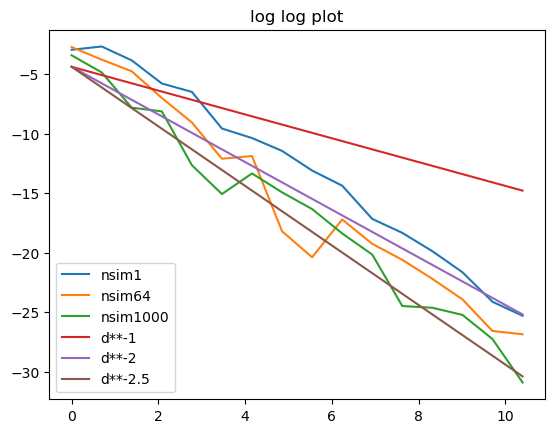

In [10]:
CVRRMC_llplt()

## DRRMC (Diagonal RRMC)
Our current examples of RMC  ignore stability problems (like stiff problem stuff). What it comes down to is big coefficients in front of recursive terms that gets multiplied multiple times which causes to variance to explode forcing you to use smaller time steps when your CVs are just doing fine. <br>  

DRRMC tries to avoid big coefficients in front of recursive terms by using an other integral representation like exponential integrators (https://en.wikipedia.org/wiki/Exponential_integrator) or like how $\bar{\sigma}$ gets chosen in Grid-Free Monte Carlo for PDEs with Spatially Varying Coefficients. 

### Derivation
Lets look at a general linear ODE IVP problem:
$$
X' = AX+g, X(0)= X_{0}.
$$ 
Let $D$ be a constant diagonal matrix
$$
X' + DX = (A+D)X+g.
$$ 
integral representation  of this is
$$
X(t)= e^{D(T-t)}X(T) + \int_{T}^{t} e^{D(s-t)}(A+D)X(s)ds+\int_{T}^{t} e^{D(s-t)}g(s)ds .
$$ 
first you should make sure that the non-recursive integral isn't a bottleneck. Now we want to chose $D$ such that multiple multiplication of $e^{D(s-t)}(A(s)+D)$ won't make things explode.<br>
Analyzing that is annoying because different $s$ give different results. We want some criteria like the geometric average of the biggest eigenvalue must be smaller then $1$. <br> 
We think that increasing $D$ element wise on the diagonal can stabilize results because in the limit $D \rightarrow \infty \Rightarrow s < t:e^{D(s-t)}(A(s)+D) \rightarrow 0 $  but $D \rightarrow \infty \Rightarrow s = t:e^{D(s-t)}(A(s)+D) \rightarrow \infty$. <br>
We haven't yet figured out how to chose $D$ at each outer recursion in general ... our best guesses now is the magnitude of the rows of $A$ or by choosing $D$ such that: 
$$
\left|\left|\tilde{X}(t)-e^{D(T-t)}X(T) -\int_{T}^{t} e^{D(s-t)}g(s)ds \right|\right|
$$ 
is small where $\tilde{X}(t)$ is a guess of $X(t)$ via the same techniques to construct CVs.  




### Example

Who cares what we think. Lets do an example. Following example comes from (https://en.m.wikipedia.org/wiki/Stiff_equation).

$$
x'= Ax, x= (1 \text{ } 0)^{T}.
$$

with

$$
A = \begin{pmatrix}
0 & 1 \\
-1000 & -1001
\end{pmatrix}.
$$

we choose $D$ fixed over all outer recursions:

$$
D = \begin{pmatrix}
1 & 0 \\
0 & 1000
\end{pmatrix}.
$$

Here is the implementation of this:


In [8]:
from random import random
from math import exp
import numpy as np
from numba import njit, prange


#returns exp(D*x) where D diagonal
@njit(fastmath =True)
def expDiag(D,x): return np.diag(np.exp(np.diag(D*x)))

@njit(fastmath =True)
def X_fast(t, T, xT,  D,A, DT):
    sol = expDiag(D,T-t) @ xT
    if random() < (t-T)/DT:
        S = T + random()*(t-T)  # \sim Uniform(T,t)
        sol += DT*expDiag(D,S-t) @ ((A+D) @ X_fast(S, T, xT, D,A,DT)) 
    return sol 

@njit(fastmath =True)
def X_slow(T, DT: "step size slow recursion"):
    x,t = np.array([1.0,0.0]),0.0
    D = np.array([[1.0,0.0],[0.0,1000.0]])
    A = np.array([[0,1],[-1000,-1001]])
    while t<T:
        tt = t+DT if t+DT<T else T
        x = X_fast(tt, t, x, D, A, tt-t) 
        t=tt
    return x


@njit(fastmath=True, parallel=True)
def solX(T, DT, nsim ):
    total = np.zeros(2)
    for _ in prange(nsim):
        total += X_slow(T,DT)
    return total/nsim

def exactX(t):
    x = -exp(-1000*t)/999 + 1000*exp(-t)/999
    dx = 1000*exp(-1000*t)/999 - 1000*exp(-t)/999
    return np.array([x,dx])


In [310]:
def testX(t):
    DTS = [0.1,0.05,0.01,0.005,0.05]
    nsims = [10**4,10**4,10**3,10**2,1]
    for DT,nsim in zip(DTS,nsims):
        error =(solX(t,DT,nsim)-exactX(t))/exactX(t) 
        print(f"DT, nsim = {DT}, {nsim}, %error = {error}")
testX(1)

DT, nsim = 0.1, 10000, %error = [0.06231436 0.74702381]
DT, nsim = 0.05, 10000, %error = [-0.0192854   0.06317045]
DT, nsim = 0.01, 1000, %error = [-0.0018453  -0.00270515]
DT, nsim = 0.005, 100, %error = [ 0.01148272 -0.06621385]
DT, nsim = 0.05, 1, %error = [ 0.61970439 -1.        ]


In this example the variance is pretty bad at the other hand classic methods struggle with stiff problems. Splitting in the inner recursion is an easy fix but it costs resources. We haven't looked at important sampling. To control variate we need an integrable approximation of: 

$$
e^{D(s-t)}(A(s)+D)X(s)
$$ 
Linearlizing this isn't great because of that exponential, the way to go is to keep the exponential and linearlizing the rest. We build a linear approximation of the rest by evaluating the rest twice up to first order details and interpolating. Call $(A(s)+D)X(s) = q(s)$
$$
q(s) \approx q(T) + \frac{s-T}{t-T} (\tilde{q}(t)-q(T)).
$$ 
where we $\tilde{q}(t)$ is an approximation of $q(t)$:
$$
\tilde{q}(t) \approx (A(t)+D)(X(T)+(t-T)(A(T)X(T)+g(T))).
$$ 
Because our control variate is basically an exponential times a polynomial it is possible to integrate it analytically:
$$
\int_{T}^{t} e^{D(s-t)} \left(q(T) + \frac{s-T}{t-T}(\tilde{q}(t) -q(T))\right) ds
$$ 
introduce following notation: $DT = t -T$, $\Delta \tilde{q} = \frac{\tilde{q}(t)-q(T)}{DT}$ do following sub in the previous integral: $u = s-T, du = ds$:
$$
\begin{align*}
\int_{T}^{t} &e^{D(s-t)} \left(q(T) + \frac{s-T}{t-T}(\tilde{q}(t) -q(T))\right) ds \\
&= \int_{0}^{DT} e^{D(u-DT)}\left( q(T) + u\Delta\tilde{q} \right)ds \\    
&= D^{-1}\left(  I - e^{-D DT}\right) q(T)  \\
    &+ \int_{0}^{DT} e^{D(u-DT)} u\Delta \tilde{q} ds \\    
&= D^{-1}\left(  I - e^{-D DT}\right) q(T)  \\
    &+ \left( D^{-1}(DT I - D^{-1}) + D^{-2}e^{-D DT} \right)\Delta \tilde{q}  \\    
 
\end{align*}
.
$$ 
You could  implement this formula with only arrays that represent the diagonal matrix. Here is our implementation:

In [1]:
from random import random
from math import exp
import numpy as np
from numba import njit, prange


#returns exp(D*x) where D diagonal
@njit(fastmath =True)
def expDiag(D,x): return np.diag(np.exp(np.diag(D*x)))

@njit(fastmath =True)
def powDiag(D,deg): return np.diag(np.power(np.diag(D),deg))

@njit(fastmath =True)
def X2_fast(t, T, xT,q,Dtilq,  D,A, DT):
    sol = expDiag(D,T-t) @ xT
    sol += powDiag(D,-1) @ ((np.identity(2)-expDiag(D,-(t-T)))@q)
    #sol += ((t-T)*powDiag(D,-1) - powDiag(D,-2)+(powDiag(D,-2)@expDiag(D,-(t-T))))@Dtilq
    if random() < (t-T)/DT:
        S = T + random()*(t-T)  # \sim Uniform(T,t)
        sol += DT*expDiag(D,S-t) @ ((A+D) @ X2_fast(S, T, xT,q,Dtilq, D,A,DT)- (q) ) #+ (S-T)*Dtilq 
    return sol 

@njit(fastmath =True)
def X2_slow(T, DT,D):
    x,t = np.array([1.0,0.0]),0.0
    A = np.array([[0.0,1.0],[-1000.0,-1001.0]])
    while t<T:
        tt = t+DT if t+DT<T else T
        tilq = (A+D)@(x+(tt-t)*(A@x))
        q = (A+D)@x
        Dtilq = (tilq-q)/(tt-t) 
        x= X2_fast(tt, t, x,q, Dtilq, D, A, tt-t) 
        t=tt
    return x


@njit(fastmath =True,parallel=True)
def solX2(T, DT, nsim,D ):
    total = np.zeros(2)
    for _ in prange(nsim):
        total += X2_slow(T,DT,D)
    return total/nsim

def exactX(t):
    x = -exp(-1000*t)/999 + 1000*exp(-t)/999
    dx = 1000*exp(-1000*t)/999 - 1000*exp(-t)/999
    return np.array([x,dx])


In [5]:
def testX2(t):
    DTS = [0.5,0.1,0.1,0.05,0.01,0.005]
    nsims = [10**3,10**2,1,1,1,1]
    D = np.array([[1.0,0.0],[0.0,1000.0]])
    for DT,nsim in zip(DTS,nsims):
        error =(solX2(t,DT,nsim,D)-exactX(t))/exactX(t) 
        print(f"DT, nsim = {DT}, {nsim}, %error = {error}")
testX2(1)

DT, nsim = 0.5, 1000, %error = [-0.24442202  0.30761855]
DT, nsim = 0.1, 100, %error = [-0.00430084 -0.01762692]
DT, nsim = 0.1, 1, %error = [-0.06697976  0.03325909]
DT, nsim = 0.05, 1, %error = [-0.02273791  0.02719425]
DT, nsim = 0.01, 1, %error = [-0.00081733  0.0081891 ]
DT, nsim = 0.005, 1, %error = [-0.001166    0.00163701]


C:\Users\Admin\AppData\Local\Temp\ipykernel_7004\3882581685.py:9: RuntimeWarning: invalid value encountered in log
  plt.plot(-np.log(DTS),np.log(errors), label = f"nsim{nsim}")


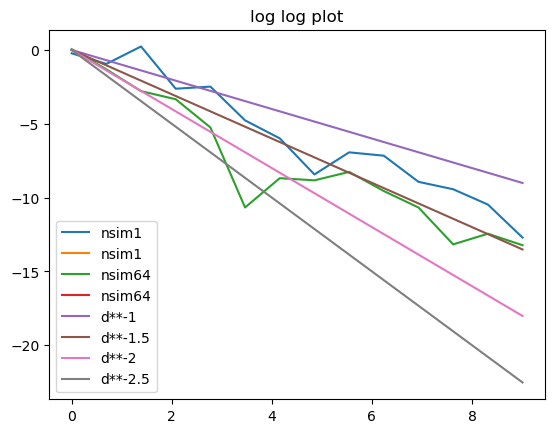

In [7]:
import matplotlib.pyplot as plt
def CVDRRMC_llplt():
    T = 1
    DTS = np.power(0.5,np.array(range(14)))
    D = np.array([[1.0,0.0],[0.0,1000.0]])
    Ns = [1,64]
    for nsim in Ns:
        errors = np.array([(abs(solX2(T, d, nsim,D )-exactX(T)))/(exactX(T)) for d in DTS])
        plt.plot(-np.log(DTS),np.log(errors), label = f"nsim{nsim}")

    dgs = [1,1.5,2,2.5]
    for l in dgs:
        ref = np.array([pow(d,l) for d in DTS])
        plt.plot(-np.log(DTS),np.log(ref),label =f"d**-{l}")
    plt.legend()
    plt.title("log log plot")
    plt.show()

CVDRRMC_llplt()

We didn't get the linear CV to work but the constant one already added significant variance reduction.